Here we perform clustering of cells using the cosine distance
$$d(u,v):=1-\frac{u\cdot v}{||u||_2||v||_2}$$
where $u$ and $v$ are vectors representing a cell and its elements are the log-transformed counts of genes expressed on the cell.

In [5]:
import pandas as pd
import numpy as np
import math
from scipy.stats import iqr
from numpy import histogram2d
from numpy import histogram
from sklearn.metrics import mutual_info_score
from matplotlib import pyplot as plt
from scipy.stats import entropy
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon
from scipy.spatial.distance import cosine
from scipy.special import kl_div
from persim import plot_diagrams 
from ripser import ripser, lower_star_img
from sklearn.cluster import KMeans
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
import seaborn as sns

Let us compute some distance between a pair of Genes of a given dataset after the logtransformation $\log(X+1)$

In [25]:
count_dataframe = pd.read_csv("ClusterCells_GE_UMAP_1D/CellSorted_SRR12615659_GE_matrix_filtered.csv", # where to find the data
                              index_col=0).T # use the first column to label the rows (the 'index')
metadata_dataframe = pd.read_csv("ClusterCells_GE_UMAP_1D/SRR12615659_cluster_sample.csv", # where to find the data
                              index_col=1)
adata = sc.AnnData(X = count_dataframe, obs = metadata_dataframe)
adata.raw = adata # store a copy of the raw values before normalizing
sc.pp.normalize_total(adata, target_sum=1) # normalize
sc.pp.log1p(adata)

We randomly choose an Epithelial, Fibroblast and Monocyte cell and compare to each other.

distance between a Epithelial cell 1 against Eputhelial 2=0.16143661737442017
distance between a Epithelial cell 1 against a Fibroblast=0.29554909467697144
distance between a Epithelial cell 1 against a Monocyte=0.30123448371887207


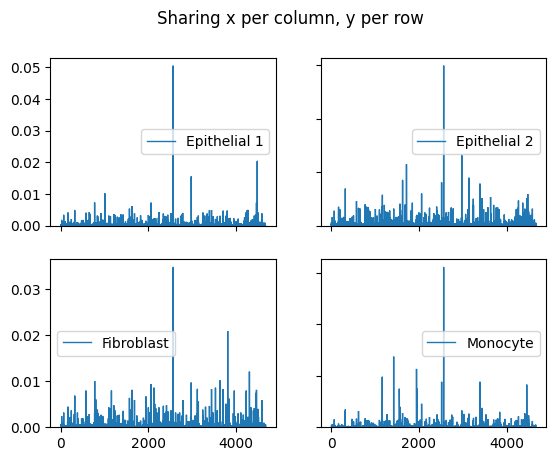

In [58]:
Epithelial = adata[adata.obs['Cell_Type'] == 'Epithelial cells']
Fibroblasts = adata[adata.obs['Cell_Type'] == 'Fibroblasts']
Monocytes = adata[adata.obs['Cell_Type'] == 'Monocytes']
print("distance between a Epithelial cell 1 against Eputhelial 2="+str(cosine(Epithelial.X[0,:],Epithelial.X[4,:]))) #between same cell
print("distance between a Epithelial cell 1 against a Fibroblast="+str(cosine(Epithelial.X[0,:],Fibroblasts.X[1,:])))
print("distance between a Epithelial cell 1 against a Monocyte="+str(cosine(Epithelial.X[0,:],Monocytes.X[0,:])))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Sharing x per column, y per row')
ax1.stairs(Epithelial.X[0,:],label='Epithelial 1')
ax2.stairs(Epithelial.X[4,:],label='Epithelial 2')
ax3.stairs(Fibroblasts.X[1,:],label='Fibroblast')
ax4.stairs(Monocytes.X[0,:],label='Monocyte')

for ax in fig.get_axes():
    ax.label_outer()
    ax.legend()

We now compute the pairwise distance matrix for different log-transformations and generate an score index of the comparison between the pre-known labels and the labels generated via kmeans.

In [1]:
def Compute_Cmatrix(adata,ver):
    batch_size_features= adata.X.shape[0]
    Mw_matrix = np.zeros((batch_size_features,batch_size_features)) #w distance matrix
    for col_i in range(0,batch_size_features):
        for col_j in range(col_i,batch_size_features):
            Mw_matrix[col_i,col_j] = cosine(adata.X[col_i,:],adata.X[col_j,:])
    Mw_matrix= Mw_matrix+Mw_matrix.T-np.diag(np.diag(Mw_matrix))
    np.savetxt('mymethod/Mc_matrix_'+ver+'.csv', Mw_matrix, delimiter=',')

def evaluate_clustering(adata,d_matrix):
    mds = MDS(n_components=5,dissimilarity='precomputed',\
          random_state=0, normalized_stress='auto')
    X_transform = mds.fit_transform(d_matrix)
    kmeans_model = KMeans(n_clusters = 4,n_init='auto')
    kmeans_model.fit(X_transform)
    adata.obs['kmeans'] = kmeans_model.labels_ 
    adata.obs['kmeans'] = adata.obs['kmeans'].astype(str)
    rand_index = adjusted_rand_score(labels_true = adata.obs['Cell_Type'], labels_pred = adata.obs['kmeans'])
    return rand_index

Computation of the distance matrix

In [2]:
ver=['cells_ARL','cells_CLR','cells_log','cells_lognorm']#ver='cells_ARL'
for normalisation in ver:
    adata = sc.read('mymethod/'+str(normalisation)+'.h5ad')
    Compute_Cmatrix(adata,str(normalisation))

Score evaluation

In [3]:
ver=['cells_ARL','cells_CLR','cells_log','cells_lognorm']
score=[]
for normalisation in ver:
    adata = sc.read('mymethod/'+str(normalisation)+'.h5ad')
    d_matrix=np.loadtxt('mymethod/Mc_matrix_'+str(normalisation)+'.csv', delimiter=',')
    score.append(evaluate_clustering(adata,d_matrix))

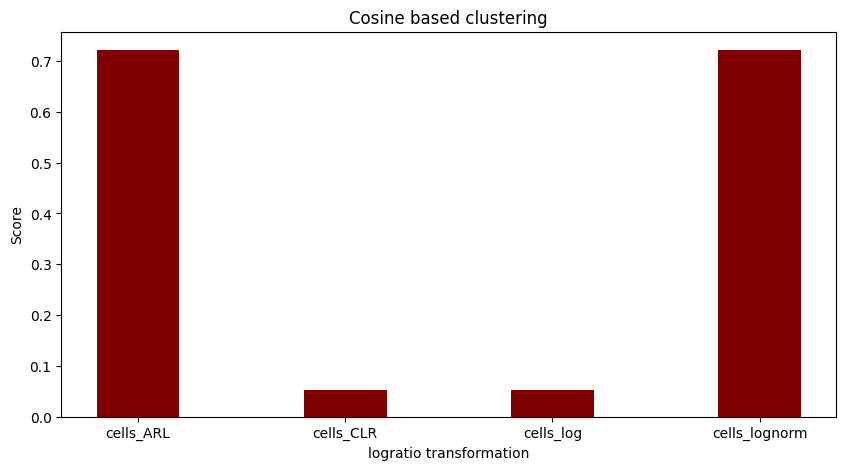

In [4]:
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(ver, score, color ='maroon',
        width = 0.4) 
plt.xlabel("logratio transformation")
plt.ylabel("Score")
plt.title("Cosine based clustering")
plt.show()

Conclusion: the cosine distance gives a 70% accuracy using ARL and lognorm transformations